# Stop 4-body decay search using QML

## Software needed

%%capture
!pip install uproot awkward
!pip install pennylane
!pip install matplotlib
!pip install sklearn
!pip install pandas

## Setup

In [1]:
import random
import uproot
import numpy

from itertools import chain

import pennylane as qml
from pennylane import numpy as np

from sklearn import decomposition
from sklearn import metrics as metrics
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split

import pandas as pd

import matplotlib.pyplot as plt

## Data

In [2]:
path = "/Users/ketchum/Desktop/STOP_nTuples/"
#path = "/Volumes/Samsung_T5/STOP_nTuples/"
trainPath = "nTuples17_nanoAOD_v2021-10-15_train/"
testPath = "nTuples17_nanoAOD_v2021-10-15_test/"
#sgName = "T2DegStop_deltaM30"
sgName = "T2DegStop_550_520"
bkName = "WJetsToLNu_HT200to400"
treename="bdttree"

myFeatures = ["Jet1Pt", "Met", "mt", "LepPt", "LepEta", "LepChg", "HT", "NbLoose","Njet", "JetHBpt", "DrJetHBLep", "JetHBDeepCSV"]
branches = ["XS","Nevt","Event","weight"]
branches.extend(myFeatures)
preSel = "(LepPt < 30) & (Met > 280) & (HT > 200) & (Jet1Pt > 110) & ((DPhiJet1Jet2 < 2.5) | (Jet2Pt < 60)) & (isTight == 1)"

In [3]:
sgTree = uproot.open(path + trainPath + sgName+".root:"+treename)
bkTree = uproot.open(path + trainPath + bkName+".root:"+treename)

sgDict = sgTree.arrays(branches,preSel,library="np")
bkDict = bkTree.arrays(branches,preSel,library="np")

In [4]:
sgJet1Pt = sgDict["Jet1Pt"]
sgMet = sgDict["Met"]
sgmt = sgDict["mt"]

bkJet1Pt = bkDict["Jet1Pt"]
bkMet = bkDict["Met"]
bkmt = bkDict["mt"]

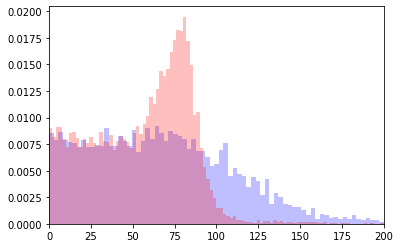

In [5]:
plt.hist(sgmt, 100, density=True, color = "blue", alpha=0.25)
plt.hist(bkmt, 100, density=True, color = "red" , alpha=0.25) #histtype='step'
plt.xlim([0, 200])
plt.show()

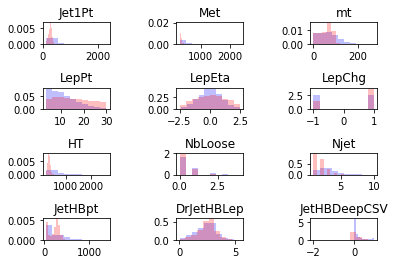

In [6]:
fig, axs = plt.subplots(4, 3)
fig.subplots_adjust(hspace = 2, wspace=1)
axs = axs.ravel()
canvas = 0

for feature in myFeatures:
    axs[canvas].hist(sgDict[feature], density=True, color = "blue", alpha=0.25)
    axs[canvas].hist(bkDict[feature], density=True, color = "red", alpha=0.25)
    axs[canvas].set_title(feature)
    canvas+= 1
    #print(feature)
plt.show()

In [7]:
# Add categoty
sgDict["category"] = numpy.ones(sgJet1Pt.size)
bkDict["category"] = -numpy.ones(bkJet1Pt.size)

In [8]:
sgDF = pd.DataFrame(sgDict)
display(sgDF)

,XS,Nevt,Event,weight,Jet1Pt,Met,mt,LepPt,LepEta,LepChg,HT,NbLoose,Njet,JetHBpt,DrJetHBLep,JetHBDeepCSV,category
0,0.347,87155.0,374122677,1.660328e-06,358.50,495.763916,66.287491,9.832875,1.825684,-1.0,517.68750,0.0,3.0,358.50000,2.477360,0.096924,1.0
1,0.347,87155.0,374122819,1.081413e-06,382.75,294.244263,106.477509,19.571440,-1.339844,-1.0,382.75000,0.0,1.0,382.75000,4.031056,0.051941,1.0
2,0.347,87155.0,374122985,8.781268e-07,263.25,452.017548,54.583851,7.002269,0.790894,1.0,299.21875,0.0,2.0,263.25000,2.182332,0.096863,1.0
3,0.347,87155.0,374123459,1.402837e-06,458.25,619.445618,15.721840,18.753944,-0.114059,1.0,753.78125,1.0,6.0,57.15625,2.474060,0.388184,1.0
4,0.347,87155.0,15721703,2.418872e-06,514.00,612.521118,46.614670,10.367803,0.696045,-1.0,569.18750,0.0,2.0,514.00000,3.283460,0.039825,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3470,0.347,87155.0,420187995,1.260655e-06,288.75,292.965515,64.782486,8.685623,-1.313232,1.0,545.43750,0.0,3.0,188.37500,0.872331,0.070007,1.0
3471,0.347,87155.0,420187999,1.456874e-06,391.25,373.897644,88.149536,11.288665,1.731689,1.0,439.31250,1.0,2.0,391.25000,2.197504,0.286865,1.0
3472,0.347,87155.0,421150243,1.339093e-06,321.00,332.120636,104.815689,9.481251,0.224731,-1.0,321.00000,0.0,1.0,321.00000,1.503235,0.066345,1.0
3473,0.347,87155.0,421150477,1.574922e-06,320.00,347.891785,5.499272,5.202309,0.810547,1.0,320.00000,1.0,1.0,320.00000,2.904480,0.526855,1.0


In [9]:
bkDF = pd.DataFrame(bkDict)
display(bkDF)

,XS,Nevt,Event,weight,Jet1Pt,Met,mt,LepPt,LepEta,LepChg,HT,NbLoose,Njet,JetHBpt,DrJetHBLep,JetHBDeepCSV,category
0,407.899994,21250516.0,186969,2.959862e-05,257.500,314.997894,13.740556,9.744009,1.150879,-1.0,337.93750,1.0,2.0,257.50000,2.776972,0.220947,-1.0
1,407.899994,21250516.0,43941855,1.416709e-05,205.625,289.707642,28.436508,13.372465,-0.232910,1.0,387.90625,1.0,3.0,138.00000,2.917414,0.163696,-1.0
2,407.899994,21250516.0,90462929,2.595884e-05,144.500,412.164795,0.787054,5.453191,-0.400940,1.0,287.75000,1.0,2.0,144.50000,3.085957,0.284424,-1.0
3,407.899994,21250516.0,90467997,1.444754e-05,293.250,342.921143,92.996017,17.136381,0.855347,-1.0,330.09375,0.0,2.0,36.84375,2.587237,0.065918,-1.0
4,407.899994,21250516.0,90663941,1.565862e-06,189.375,290.784393,83.576836,6.006060,-0.061378,1.0,244.93750,0.0,2.0,55.56250,1.127103,0.043488,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14066,407.899994,21250516.0,152637049,1.754597e-05,295.500,313.942108,37.779633,10.321433,-0.027855,-1.0,295.50000,0.0,1.0,295.50000,2.600261,0.023087,-1.0
14067,407.899994,21250516.0,155856527,1.467571e-05,394.750,370.734650,48.072338,18.051493,-0.984985,1.0,394.75000,0.0,1.0,394.75000,2.614589,0.018326,-1.0
14068,407.899994,21250516.0,155859873,3.303919e-07,327.750,357.940735,11.259412,16.103882,-2.321289,-1.0,327.75000,0.0,1.0,327.75000,3.275612,0.049957,-1.0
14069,407.899994,21250516.0,151989749,1.536704e-05,323.750,296.777802,71.233147,10.747914,1.748535,1.0,356.31250,0.0,2.0,32.56250,0.923977,0.073486,-1.0


In [10]:
def dataForQDevice(n_samples, sampleDict, features):
    tensor = np.zeros([n_samples,len(features)])
    for i in range(0,n_samples):
        event = np.zeros([1,len(features)])
        for j in range(0,len(features)):
            event[0][j] = sampleDict[features[j]][i]
        tensor[i] = event
    
    return tensor

In [11]:
#n_samples = 3000 #500
n_samples = 50

features = ["LepPt", "Met", "Jet1Pt","mt"]
#features = myFeatures

X0 = dataForQDevice(n_samples,sgDict,features)
X1 = dataForQDevice(n_samples,bkDict,features)

Y0 = np.array(sgDict["category"][:n_samples])
Y1 = np.array(bkDict["category"][:n_samples])

X = np.concatenate([X0,X1], axis=0)
Y = np.concatenate([Y0,Y1], axis=0)

# normalize data
X = minmax_scale(X,feature_range=(0, numpy.pi))

# split data into train + validation and test
X_train_val , X_test , y_train_val , y_test=train_test_split(X , Y , test_size=0.2)

## Quantum

In [12]:
n_qubits = X.shape[1]

In [13]:
# quantum device
dev = qml.device('default.qubit', wires=n_qubits)
#dev = qml.device('default.mixed', wires=n_qubits)
#dev = qml.device('qiskit.aer', wires=n_qubits)

In [14]:
# quantum circuit
@qml.qnode(dev)
def circuit(weights, x=None):
    qml.templates.AngleEmbedding(x, wires=range(n_qubits))
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    #qml.templates.BasicEntanglerLayers(w, wires=range(n_qubits))
    return qml.expval(qml.PauliZ(wires=0))

# variational quantum classifier
def variational_classifier(theta_weights, theta_bias, x=None):
    weights=theta_weights
    bias=theta_bias
    return circuit(weights, x=x)+bias

In [15]:
# number of quantum layers
n_layers = 3
#n_layers = len(features)+1

# draw random quantum node weights / initial weights
theta_weights = 0.01 * np.random.randn(n_layers, n_qubits, 3, requires_grad=True)
theta_bias = np.array(0.0, requires_grad=True)

circuit(theta_weights, X[2])
drawer = qml.draw(circuit)
print(qml.draw(circuit)(theta_weights, X[2]))

 0: ──╭AngleEmbedding(M0)──╭StronglyEntanglingLayers(M1)──┤ ⟨Z⟩ 
 1: ──├AngleEmbedding(M0)──├StronglyEntanglingLayers(M1)──┤     
 2: ──├AngleEmbedding(M0)──├StronglyEntanglingLayers(M1)──┤     
 3: ──╰AngleEmbedding(M0)──╰StronglyEntanglingLayers(M1)──┤     
M0 =
[0.39993115 0.76634718 0.53143038 0.76456724]
M1 =
[[[ 0.00455838 -0.00399299  0.01002206]
  [ 0.0003182   0.01320788 -0.0045427 ]
  [-0.01022958  0.00238073  0.00239885]
  [-0.00056781  0.01414905 -0.00122134]]

 [[ 0.01570556  0.00388197  0.0069089 ]
  [ 0.01395826 -0.00086653 -0.01173247]
  [ 0.00194919  0.01009563  0.00680878]
  [ 0.00166272  0.00286275 -0.00071683]]

 [[-0.01483681  0.00398409 -0.00137538]
  [-0.00413812 -0.00700581 -0.00169406]
  [ 0.00235192 -0.00453115  0.00346755]
  [-0.00194344  0.00516977 -0.00642271]]]



<ipython-input-16-d4b101a913df>:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


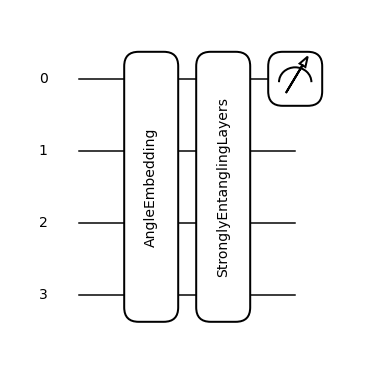

In [16]:
qml.drawer.use_style('black_white')
fig, ax = qml.draw_mpl(circuit)(theta_weights, X_test[2])
fig.show()

## Training

In [17]:
# split into train and validation
X_train , X_val , y_train , y_val = train_test_split(X_train_val, y_train_val, test_size =0.20)

# pca
#pca = decomposition.PCA(n_components=len(features)).fit(X_train)
#X_train = pca.transform(X_train)
#X_val = pca.transform(X_val)

data_train = list(zip(X_train, y_train))
data_val  = list(zip(X_val, y_val))

# select learning batch size
batch_size = 10

# calculate number of batches
batches = len(X_train)// batch_size

# select number of epochs
n_epochs = 15

In [18]:
batches

6

In [19]:
# build the optimizer object
#pennylane_opt = qml.GradientDescentOptimizer(0.2)
#pennylane_opt = qml.NesterovMomentumOptimizer(0.01)
pennylane_opt = qml.NesterovMomentumOptimizer(0.3)

In [20]:
def loss(a, b):
    return (a - b)**2

def average_loss(theta_weights, theta_bias, data):
    c = 0
    for x, y in data:
        prediction = variational_classifier(theta_weights, theta_bias, x)
        #prediction = np.sign(variational_classifier(theta_weights, theta_bias, x))
        c += loss(prediction, y)
    return c/len(data)

In [21]:
def accuracy(theta_weights, theta_bias, data):
    y_pred = []
    y_true = []

    for x, y in data:
        prediction = np.sign(variational_classifier(theta_weights, theta_bias, x))
        y_pred.append(prediction)
        y_true.append(y)

    accuracy = metrics.accuracy_score(y_true, y_pred)
    return accuracy    

In [22]:
def pred(theta_weights, theta_bias, X):
    y_pred = []
    for x in X:
        prediction = variational_classifier(theta_weights, theta_bias, x)
        y_pred.append(prediction)
        
    return y_pred

In [23]:
loss_train  = []
loss_val    = []
accur_train = []
accur_val   = []

In [24]:
for i in range(n_epochs):
    #avg_loss_train = average_loss(theta_weights, theta_bias, data_train)
    ([theta_weights, theta_bias], avg_loss_train) = pennylane_opt.step_and_cost(
    lambda theta_weights_, theta_bias_: average_loss(
        theta_weights_, theta_bias_, data_train), theta_weights, theta_bias)
    loss_train.append(avg_loss_train)
    avg_loss_val = average_loss(theta_weights, theta_bias, data_val)
    loss_val.append(avg_loss_val)
    
    acc_train = accuracy(theta_weights, theta_bias, data_train)
    acc_val = accuracy(theta_weights, theta_bias, data_val)
    accur_train.append(acc_train)
    accur_val.append(acc_val)

    print("Epoch: {:2d} | Loss: {:0.7f} | Acc train: {:0.4f} val: {:0.4f}"
          "".format(i + 1, avg_loss_train, acc_train, acc_val))

Epoch:  1 | Loss: 1.6874381 | Acc train: 0.4844 val: 0.4375
Epoch:  2 | Loss: 1.3110555 | Acc train: 0.5781 val: 0.4375
Epoch:  3 | Loss: 1.3766665 | Acc train: 0.5625 val: 0.4375
Epoch:  4 | Loss: 1.3095542 | Acc train: 0.5781 val: 0.4375
Epoch:  5 | Loss: 1.2458525 | Acc train: 0.6094 val: 0.4375
Epoch:  6 | Loss: 1.1827712 | Acc train: 0.5938 val: 0.4375
Epoch:  7 | Loss: 1.0918629 | Acc train: 0.5938 val: 0.5000
Epoch:  8 | Loss: 1.0064918 | Acc train: 0.7344 val: 0.6250
Epoch:  9 | Loss: 0.9386035 | Acc train: 0.7031 val: 0.6875
Epoch: 10 | Loss: 0.8889818 | Acc train: 0.7344 val: 0.7500
Epoch: 11 | Loss: 0.8499265 | Acc train: 0.7500 val: 0.8125
Epoch: 12 | Loss: 0.8107384 | Acc train: 0.7656 val: 0.8125
Epoch: 13 | Loss: 0.7640788 | Acc train: 0.7812 val: 0.8125
Epoch: 14 | Loss: 0.7100993 | Acc train: 0.7969 val: 0.7500
Epoch: 15 | Loss: 0.6677898 | Acc train: 0.8125 val: 0.7500


# split training data into batches
X_batches = np . array_split ( np . arange ( len ( X_train )) , batches )
for it , batch_index in enumerate ( chain (*( n_epochs * [ X_batches ]))):
    batch_cost = \
96 lambda theta : cost ( theta , X_train [ batch_index ] , e_train [ batch_index ])
97 theta = pennylane_opt . step ( batch_cost , theta )
98 # use X_validation and y_validation to decide whether to stop
99 # end of learning loop

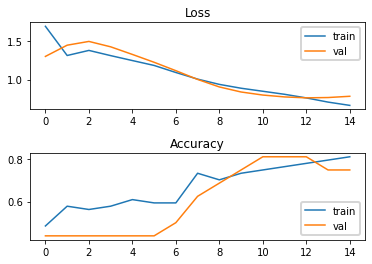

In [25]:
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.subplots_adjust(hspace = 0.5, wspace=0)
ax1.set_title("Loss")
ax1.plot(loss_train, label="train")
ax1.plot(loss_val, label="val")
ax1.legend(loc="upper right")
ax2.set_title("Accuracy")
ax2.plot(accur_train, label="train")
ax2.plot(accur_val, label="val")
ax2.legend(loc="lower right")

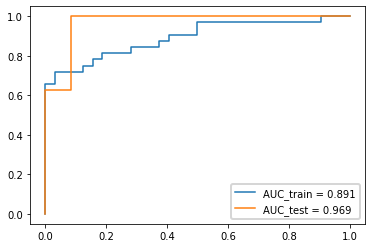

In [26]:
y_pred_train = pred(theta_weights, theta_bias, X_train)
y_pred_test  = pred(theta_weights, theta_bias, X_test)

fpr_train, tpr_train, thresholds_train = metrics.roc_curve(y_train, y_pred_train)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_test)

roc_auc_train = metrics.auc(fpr_train,tpr_train)
roc_auc = metrics.auc(fpr,tpr)

plt.plot(fpr_train,tpr_train, label='AUC_train = %0.3f' % (roc_auc_train))
plt.plot(fpr,tpr, label='AUC_test = %0.3f' % (roc_auc))
plt.legend(loc="lower right")

In [29]:
#print(qml.draw(circuit)(theta_weights, X[2]))

In [30]:
def pred3(theta_weights, theta_bias, X):
    y_pred = numpy.array([])
    for x in X:
        #prediction = np.sign(variational_classifier(theta_weights, theta_bias, x))
        prediction = variational_classifier(theta_weights, theta_bias, x)
        y_pred = numpy.append(y_pred,prediction)
        
    return y_pred

In [33]:
y_sig = pred3(theta_weights, theta_bias, X0)
y_bkg = pred3(theta_weights, theta_bias, X1)

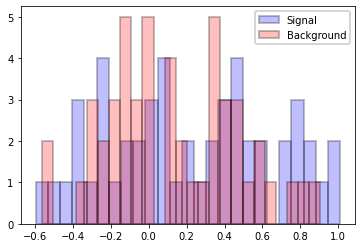

In [35]:
plt.hist(y_sig, n_samples//2, color = "blue", alpha=0.25, label="Signal")
plt.hist(y_bkg, n_samples//2, color = "red" , alpha=0.25, label="Background") #histtype='step'
#plt.xlim([-1, 1])
plt.legend(loc="best")
plt.show()

## split training data into batches
X_batches = np.array_split(np.arange(len(X_train)), batches) 
for it, batch_index in enumerate(chain(*(n_epochs*[X_batches]))):
    batch_cost = lambda theta:cost(theta, X_train[batch_index], y_train[batch_index])
    theta = pennylane_opt.step(batch_cost, theta)

https://conference.ippp.dur.ac.uk/event/929/attachments/3968/4559/piotr_gawron_quantum_neural_networks.pdf

https://pennylane.ai/qml/demos/tutorial_variational_classifier.html

https://youtu.be/YtepXvx5zdI